In [1]:
!pip install ktrain

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.3/25.3 MB 55.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 KB 60.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.0/266.0 KB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 98.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 76.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.8/468.8 KB 23.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━

In [15]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import os
os.environ["CUDA_DEVICE_FOLDER"]="PCI_BUS_ID";
os.environ["CUDA_VISIBLE_DEVICES"]="0";

In [16]:
import ktrain
from ktrain import text
from sklearn.datasets import fetch_20newsgroups

In [17]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import re
import pandas as pd
import nltk
nltk.download('words')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
ps=PorterStemmer()

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [18]:
newsgroups=fetch_20newsgroups(subset='all')
df=pd.DataFrame(newsgroups.data,columns=['text'])
df['categories']=[newsgroups.target_names[index] for index in newsgroups.target]
df.head(8)

,text,categories
0,From: Mamatha Devineni Ratnam <mr47+@andrew.cm...,rec.sport.hockey
1,From: mblawson@midway.ecn.uoknor.edu (Matthew ...,comp.sys.ibm.pc.hardware
2,From: hilmi-er@dsv.su.se (Hilmi Eren)\nSubject...,talk.politics.mideast
3,From: guyd@austin.ibm.com (Guy Dawson)\nSubjec...,comp.sys.ibm.pc.hardware
4,From: Alexander Samuel McDiarmid <am2o+@andrew...,comp.sys.mac.hardware
5,From: tell@cs.unc.edu (Stephen Tell)\nSubject:...,sci.electronics
6,From: lpa8921@tamuts.tamu.edu (Louis Paul Adam...,comp.sys.mac.hardware
7,From: dchhabra@stpl.ists.ca (Deepak Chhabra)\n...,rec.sport.hockey


In [19]:
# Convert multiple whitespace characters into a space
df['text'] = df['text'].str.replace('\s+',' ')

# Change newsgroup titles to use underscores rather than periods
df['categories'] = df['categories'].str.replace('.','_')

# Trim leading and tailing whitespace
df['text'] = df['text'].str.strip()

# Truncate all fields to the maximum field length of 128kB
df['text'] = df['text'].str.slice(0,131072)

# Remove any rows with empty fields
df = df.replace('', np.NaN).dropna()

# Drop duplicates
df = df.drop_duplicates(subset='text')

# Limit rows to maximum of 100,000
df = df.sample(min(100000, len(df)))

df.head(5)

,text,categories
4851,From: jim.zisfein@factory.com (Jim Zisfein) Su...,sci_med
1231,From: G.R.Price@cm.cf.ac.uk (and thats a fact)...,rec_sport_baseball
10978,From: egreen@east.sun.com (Ed Green - Pixel Cr...,rec_motorcycles
10726,From: andy@ie.utoronto.ca (Andy Sun) Subject: ...,comp_sys_mac_hardware
10327,From: cfaehl@vesta.unm.edu (Chris Faehl) Subje...,talk_religion_misc


In [20]:
#csv_str = df.to_csv(index=False, header=False)

csv_str= df.to_csv("20-newsgroups-dataset.csv",index=False)
print(csv_str)
#with open("20-newsgroups-dataset.csv", "w") as text_file:
#    print(csv_str, file=text_file)
#df=pd.read_csv("/content/20-newsgroups-dataset.csv")
#df

None


In [21]:
df=pd.read_csv("/content/20-newsgroups-dataset.csv")

df.head()

,text,categories
0,From: jim.zisfein@factory.com (Jim Zisfein) Su...,sci_med
1,From: G.R.Price@cm.cf.ac.uk (and thats a fact)...,rec_sport_baseball
2,From: egreen@east.sun.com (Ed Green - Pixel Cr...,rec_motorcycles
3,From: andy@ie.utoronto.ca (Andy Sun) Subject: ...,comp_sys_mac_hardware
4,From: cfaehl@vesta.unm.edu (Chris Faehl) Subje...,talk_religion_misc


In [22]:
def dataset_cleaning(df_data):
    """This function helps to remove row with missing value or if there is any dupicate records"""
    df = df_data.dropna()
    df_data = df_data.drop_duplicates()
    df_data = df_data.reset_index(drop=True)
    return df_data

def text_cleaning(text):
    """This function helps to clean a text after removing stop words, short words, special character,
    any link present and use stemmer to provide near to root word"""
    stop = set(stopwords.words('english'))
    text = text.lower()
    text = re.sub('[^abcdefghijklmnopqrstuvwxyz]',' ', text)
    text = re.sub(r'http\S+', ' ', text)
    text = " ".join([ps.stem(word) for word in text.split() if (word not in stop) and len(word)>1])
    return text

In [23]:
dataset = dataset_cleaning(df)
dataset

,text,categories
0,From: jim.zisfein@factory.com (Jim Zisfein) Su...,sci_med
1,From: G.R.Price@cm.cf.ac.uk (and thats a fact)...,rec_sport_baseball
2,From: egreen@east.sun.com (Ed Green - Pixel Cr...,rec_motorcycles
3,From: andy@ie.utoronto.ca (Andy Sun) Subject: ...,comp_sys_mac_hardware
4,From: cfaehl@vesta.unm.edu (Chris Faehl) Subje...,talk_religion_misc
...,...,...
18841,From: klinger@ccu.umanitoba.ca (Jorg Klinger) ...,rec_motorcycles
18842,From: bjgrier@bnr.ca (Brian Grier) Subject: Re...,comp_os_ms-windows_misc
18843,From: dino@inqmind.bison.mb.ca (Tony stewart) ...,sci_electronics
18844,From: mebonar@sn01.sncc.lsu.edu (MsciDave) Sub...,rec_sport_baseball


In [24]:
dataset.shape

(18846, 2)

In [25]:
#randomly choose 25%data randomly to fine-tune model & make it faster
dataset=dataset.sample(frac=0.25)

In [26]:
dataset['cleaned_text']=dataset['text'].apply(lambda x:text_cleaning(x))
dataset.head()

,text,categories,cleaned_text
3315,From: bskendig@netcom.com (Brian Kendig) Subje...,talk_religion_misc,bskendig netcom com brian kendig subject list ...
10205,From: kempmp@phoenix.oulu.fi (Petri Pihko) Sub...,alt_atheism,kempmp phoenix oulu fi petri pihko subject con...
8683,From: goudswaa@fraser.sfu.ca (Peter Goudswaard...,comp_os_ms-windows_misc,goudswaa fraser sfu ca peter goudswaard subjec...
10814,From: atterlep@vela.acs.oakland.edu (Cardinal ...,soc_religion_christian,atterlep vela ac oakland edu cardin ximenez su...
8898,From: cutter@gloster.via.mind.org (cutter) Sub...,talk_politics_misc,cutter gloster via mind org cutter subject nc ...


In [38]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(np.array(dataset['cleaned_text']),np.array(dataset['categories']),
                                               test_size = 0.20, random_state=42, stratify = dataset['categories'])


In [39]:
MODEL_NAME ='distilbert-base-uncased'
t=text.Transformer(MODEL_NAME,maxlen=512,classes=dataset['categories'].unique()) #maxlen-> max len of tokenisation
train=t.preprocess_train(X_train,y_train) #prepare train& test dataset for transformer
val=t.preprocess_test(X_test,y_test)
model=t.get_classifier() #get distill bert classifier
learner=ktrain.get_learner(model,train_data=train,val_data=val,batch_size=20)

preprocessing train...
language: en
train sequence lengths:
	mean : 175
	95percentile : 400
	99percentile : 1315


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 191
	95percentile : 485
	99percentile : 2264


simulating training for different learning rates... this may take a few moments...
Epoch 1/5
188/188 [==============================] - 222s 1s/step - loss: 2.9819 - accuracy: 0.0822
Epoch 2/5
188/188 [==============================] - 210s 1s/step - loss: 1.9094 - accuracy: 0.4817
Epoch 3/5
188/188 [==============================] - 208s 1s/step - loss: 2.7534 - accuracy: 0.1288
Epoch 4/5
188/188 [==============================] - 202s 1s/step - loss: 3.0586 - accuracy: 0.0515
Epoch 5/5
188/188 [==============================] - 200s 1s/step - loss: 5.0745 - accuracy: 0.0501


done.
Visually inspect loss plot and select learning rate associated with falling loss


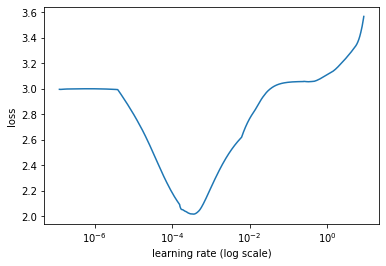

In [40]:
learner.lr_find(show_plot=True,max_epochs=5) 

In [41]:
learner.fit_onecycle(2e-5, 5) 



begin training using onecycle policy with max lr of 2e-05...
Epoch 1/5
189/189 [==============================] - 245s 1s/step - loss: 2.4983 - accuracy: 0.3181 - val_loss: 1.7261 - val_accuracy: 0.5504
Epoch 2/5
189/189 [==============================] - 229s 1s/step - loss: 1.3059 - accuracy: 0.6532 - val_loss: 1.0170 - val_accuracy: 0.6957
Epoch 3/5
189/189 [==============================] - 229s 1s/step - loss: 0.7665 - accuracy: 0.7734 - val_loss: 0.7698 - val_accuracy: 0.7773
Epoch 4/5
189/189 [==============================] - 229s 1s/step - loss: 0.4585 - accuracy: 0.8700 - val_loss: 0.6714 - val_accuracy: 0.8017
Epoch 5/5
189/189 [==============================] - 230s 1s/step - loss: 0.2926 - accuracy: 0.9353 - val_loss: 0.6355 - val_accuracy: 0.8155


In [42]:
learner.validate()

30/30 [==============================] - 20s 620ms/step
              precision    recall  f1-score   support

           0       0.79      0.79      0.79        42
           1       0.58      0.75      0.65        48
           2       0.63      0.80      0.71        50
           3       0.60      0.58      0.59        50
           4       0.71      0.70      0.71        50
           5       0.95      0.69      0.80        51
           6       0.79      0.76      0.77        49
           7       0.89      0.87      0.88        45
           8       0.93      0.85      0.89        46
           9       0.96      0.96      0.96        51
          10       1.00      0.98      0.99        49
          11       0.95      0.95      0.95        44
          12       0.79      0.76      0.78        50
          13       0.95      0.88      0.91        48
          14       0.91      0.98      0.94        52
          15       0.85      0.81      0.83        48
          16       0.88  

array([[33,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  3,  0,  6],
       [ 0, 36,  3,  1,  4,  1,  1,  0,  0,  0,  0,  1,  0,  0,  1,  0,
         0,  0,  0,  0],
       [ 0,  5, 40,  2,  0,  1,  1,  1,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [ 0,  1, 10, 29,  3,  0,  3,  0,  0,  0,  0,  0,  4,  0,  0,  0,
         0,  0,  0,  0],
       [ 0,  2,  1,  8, 35,  0,  2,  0,  0,  0,  0,  0,  1,  0,  0,  0,
         0,  1,  0,  0],
       [ 0,  7,  8,  0,  0, 35,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [ 0,  1,  1,  3,  3,  0, 37,  1,  0,  0,  0,  0,  2,  0,  0,  0,
         1,  0,  0,  0],
       [ 0,  1,  0,  0,  0,  0,  0, 39,  1,  0,  0,  0,  0,  0,  1,  0,
         0,  0,  1,  2],
       [ 0,  1,  0,  0,  0,  0,  0,  2, 39,  0,  0,  1,  1,  0,  0,  0,
         0,  1,  1,  0],
       [ 1,  0,  0,  0,  0,  0,  0,  0,  1, 49,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0

In [43]:
predictor=ktrain.get_predictor(learner.model,preproc=t)

In [44]:
#Lets take a sample news
news_text = dataset['cleaned_text'].iloc[5]
actual_category = dataset['categories'].iloc[5]
print(f"Actual category is {actual_category}")

Actual category is sci_crypt


In [45]:
print(f"prdicted category is{predictor.predict(dataset['cleaned_text'].iloc[5])}")

1/1 [==============================] - 0s 91ms/step
prdicted category issci_crypt


In [50]:
reloaded_predictor = ktrain.load_predictor('/content/distilbert')
reloaded_predictor.predict(dataset['cleaned_text'].iloc[5])
print(f"confidence score: {np.max(reloaded_predictor.predict_proba(dataset['cleaned_text'].iloc[5]))}")

1/1 [==============================] - 0s 87ms/step
confidence score: 0.957402229309082


In [49]:
predictor.save('/content/distilbert')